In [1]:
import numpy as np
import matplotlib.pyplot as plt

# plot trajectory

In [75]:
goal_point = np.array([1, 1, 0.45])
point_count = 100
start_point = np.array([0, 0, 0])

In [76]:
simple_trajectory = np.zeros((point_count, 3))
simple_trajectory[:, 0] = np.linspace(start_point[0], goal_point[0], point_count)
simple_trajectory[:, 1] = np.linspace(start_point[1], goal_point[1], point_count)
simple_trajectory[:, 2] = np.linspace(start_point[2], goal_point[2], point_count)

In [77]:
def plot_trajectory(trajectory):
    plt.plot(trajectory[:, 0], trajectory[:, 1])
    plt.quiver(trajectory[:, 0], trajectory[:, 1], np.cos(trajectory[:, 2]), np.sin(trajectory[:,2]), 
               scale=15, headlength=5, headwidth=2)
    plt.gca().set_aspect('equal')

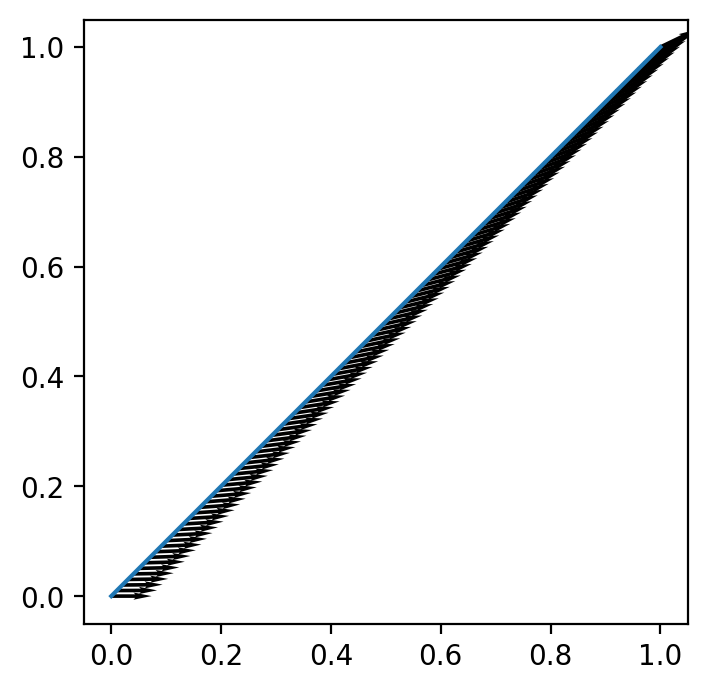

In [78]:
plt.figure(dpi=200)
plot_trajectory(simple_trajectory)

# Optimize simple trajectory

## Scipy optimization

In [80]:
from scipy.optimize import minimize

In [111]:
def trajectory_loss(dpoints, angle_koef):
    return np.sum(dpoints[:, :2] ** 2) + np.sum(angle_koef * dpoints[:, 2] ** 2)

def loss_function(trajectory, start_point, goal_point, angle_koef=1.):
    trajectory = trajectory.reshape(-1, 3)
    dpoints = (trajectory - np.roll(trajectory, 1, axis=0))[1:]
#     print(dpoints)
    loss = trajectory_loss(dpoints, angle_koef)
    loss += trajectory_loss(trajectory[:1] - start_point[None], angle_koef)
    loss += trajectory_loss(goal_point[None] - trajectory[-1:], angle_koef)
    return loss

In [112]:
loss_function(simple_trajectory, start_point, goal_point)

0.022247474747474745

In [114]:
zero_trajectory = np.zeros((point_count, 3))
result = minimize(loss_function, zero_trajectory, args=(start_point, goal_point))
loss_function(result.x, start_point, goal_point)

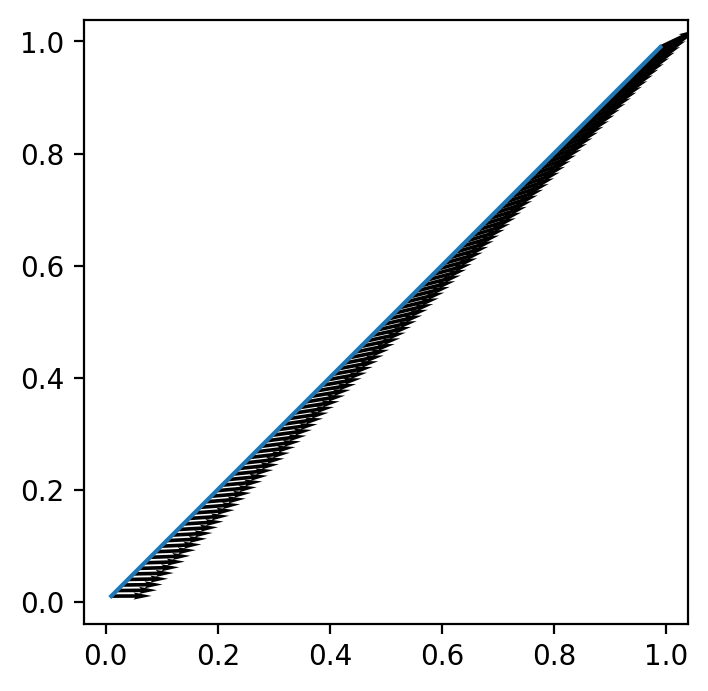

In [116]:
plt.figure(dpi=200)
plot_trajectory(result.x.reshape(-1, 3))

## Scipy with jacobian

In [134]:
def jacobian_function(trajectory, start_point, goal_point, angle_koef=1.):
    trajectory = trajectory.reshape(-1, 3)
    jacobian = np.zeros_like(trajectory)
    dpoints = (trajectory - np.roll(trajectory, 1, axis=0))[1:]
    jacobian[1:] = 2 * dpoints
    jacobian[:-1] += -2 * dpoints
    jacobian[0] += 2 * (trajectory[0] - start_point)
    jacobian[-1] += 2 * (trajectory[-1] - goal_point)
    jacobian[:, 2] *= angle_koef
    return jacobian.reshape(-1)

In [135]:
zero_trajectory = np.zeros((point_count, 3))
result = minimize(loss_function, zero_trajectory, args=(start_point, goal_point), jac=jacobian_function)
loss_function(result.x, start_point, goal_point)

0.021806930711550876

# Holonomy constraints

In [200]:
def constraints_loss(dpoints, angles):
    return np.sum(((dpoints[:, 0] * np.sin(angles) - dpoints[:, 1] * np.cos(angles))) ** 2) * 200

def constraints_loss_function(x, start_point, goal_point, angle_koef=1.):
    point_count = (len(x) - 1) // 4
    trajectory = x.reshape(-1, 3)
    dpoints = (trajectory - np.roll(trajectory, 1, axis=0))[1:]
    loss = trajectory_loss(dpoints, angle_koef)
    loss += trajectory_loss(trajectory[:1] - start_point[None], angle_koef)
    loss += trajectory_loss(goal_point[None] - trajectory[-1:], angle_koef)
    loss += constraints_loss(dpoints, trajectory[1:, 2])
    loss += constraints_loss(trajectory[:1] - start_point[None], start_point[2])
    loss += constraints_loss(trajectory[-1:] - goal_point[None], goal_point[2])
    return loss

In [201]:
def trajectory_with_lkoefs(trajectory, lkoefs):
    points_count = len(trajectory)
    result = np.zeros(len(trajectory) * 4 + 1)
    result[:3 * points_count] = trajectory.reshape(-1)
    result[3 * points_count:] = lkoefs
    return result

In [202]:
constraints_loss_function(simple_trajectory, start_point, goal_point)

1.1851026877761277

In [203]:
zero_trajectory = np.zeros((point_count, 3))
result = minimize(constraints_loss_function, simple_trajectory, args=(start_point, goal_point))
constraints_loss_function(result.x, start_point, goal_point)

0.04924110300453381

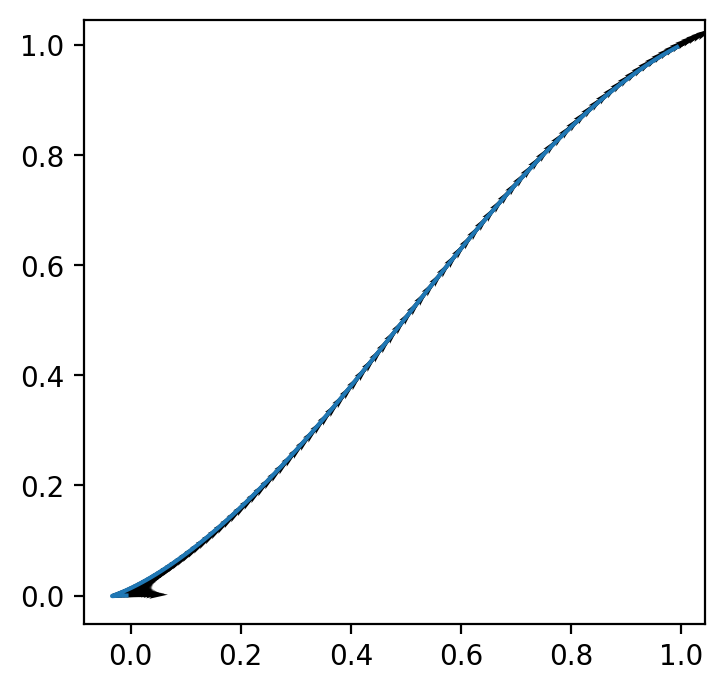

In [204]:
plt.figure(dpi=200)
plot_trajectory(result.x.reshape(-1, 3))

In [ ]:
def jacobian_function(trajectory, start_point, goal_point, angle_koef=1.):
    trajectory = trajectory.reshape(-1, 3)
    jacobian = np.zeros_like(trajectory)
    dpoints = (trajectory - np.roll(trajectory, 1, axis=0))[1:]
    jacobian[1:] = 2 * dpoints
    jacobian[:-1] += -2 * dpoints
    jacobian[0] += 2 * (trajectory[0] - start_point)
    jacobian[-1] += 2 * (trajectory[-1] - goal_point)
    jacobian[:, 2] *= angle_koef
    return jacobian.reshape(-1)

In [198]:
import torch

x = torch.tensor(10, requires_grad=True, dtype=torch.float64)
y = torch.tensor(0, requires_grad=True, dtype=torch.float64)
l = torch.tensor(-100, requires_grad=True, dtype=torch.float64)
lr = 0.1

# min x^2+y^2 s.t x+y = 1
for i in range(100):
    L = x**2 + y**2 + l*(1-x-y)
    L.backward()
    x.data.add_(-lr*x.grad.data)
    y.data.add_(-lr*y.grad.data)
    x.grad.detach_()
    x.grad.zero_()
    y.grad.detach_()
    y.grad.zero_()
    l.grad.detach_()
    l.grad.zero_()
    L = x**2 + y**2 + l*(1-x-y)
    L.backward()
    l.data.add_(lr*l.grad.data)
    x.grad.detach_()
    x.grad.zero_()
    y.grad.detach_()
    y.grad.zero_()
    l.grad.detach_()
    l.grad.zero_()

print(x, y, x+y)

tensor(0.5008, dtype=torch.float64, requires_grad=True) tensor(0.5008, dtype=torch.float64, requires_grad=True) tensor(1.0016, dtype=torch.float64, grad_fn=<AddBackward0>)


In [199]:
print(l)

tensor(1.0020, dtype=torch.float64, requires_grad=True)
